In [7]:
#nltk download data
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /home/blackcat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [63]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#visual import
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#etc
from math import log, sqrt
import json
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [182]:
#read file
dataset = open("dataset/tweets-dataset-shuff.js").read()
list_data = dataset.split("\n")

In [184]:
dict_frame = {}
dict_frame['tweet'] = []
dict_frame['label'] = []
total_data = 0
#loop for each data
for data in list_data :
    if (data == "") :
        continue
    content = json.loads(data)
    dict_frame['tweet'].append(content['tweet'])
    dict_frame['label'].append(content['label'])
    total_data += 1

dataframe = pd.DataFrame(dict_frame) 
dataframe.head()

,tweet,label
0,The Marvelous Mrs Maisels Rejection of Having ...,news
1,Send us your music videos now! #music #videos ...,promo
2,Exclusive indie artist #Datpiff Bronze #Mixtap...,promo
3,The Syria Pullout Wont Help Trump Curb Irans R...,news
4,#cigar podcast publishers Did You Know? You ca...,news


In [185]:
dataframe['label'].value_counts()

promo    27587
news     25586
Name: label, dtype: int64


# Make Word Cloud


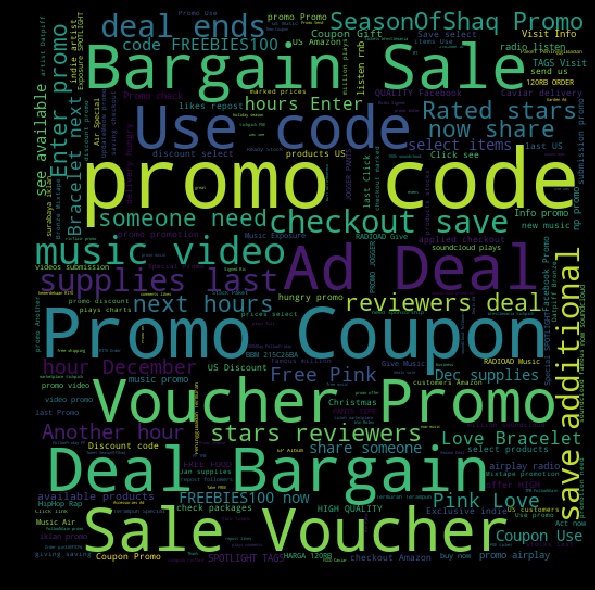

In [82]:
promo_words = ' '.join(list(dataframe[dataframe['label'] == 'promo']['tweet']))
promo_wc = WordCloud(width = 512,height = 512).generate(promo_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(promo_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

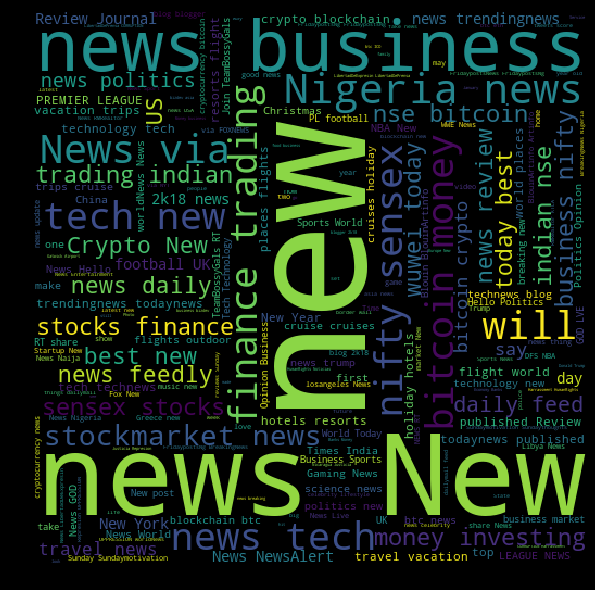

In [83]:
news_words = ' '.join(list(dataframe[dataframe['label'] == 'news']['tweet']))
news_wc = WordCloud(width = 512,height = 512).generate(news_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(news_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


# Replace Label to 1 and 0


In [186]:
dataframe['labels'] = dataframe['label'].map({'news': 0, 'promo': 1})
dataframe.head()

,tweet,label,labels
0,The Marvelous Mrs Maisels Rejection of Having ...,news,0
1,Send us your music videos now! #music #videos ...,promo,1
2,Exclusive indie artist #Datpiff Bronze #Mixtap...,promo,1
3,The Syria Pullout Wont Help Trump Curb Irans R...,news,0
4,#cigar podcast publishers Did You Know? You ca...,news,0


In [187]:
dataframe.drop(['label'], axis = 1, inplace = True)
dataframe.head()

,tweet,labels
0,The Marvelous Mrs Maisels Rejection of Having ...,0
1,Send us your music videos now! #music #videos ...,1
2,Exclusive indie artist #Datpiff Bronze #Mixtap...,1
3,The Syria Pullout Wont Help Trump Curb Irans R...,0
4,#cigar podcast publishers Did You Know? You ca...,0



# Make Train and Test Dataset


In [188]:
train_index, test_index = list(), list()
for x in range(dataframe.shape[0]):
    if np.random.uniform(0, 1) < 0.75:  # make train data 75 % and test 25 %
        train_index += [x]
    else:
        test_index += [x]
        
train_data = dataframe.loc[train_index]
test_data = dataframe.loc[test_index]

In [189]:
train_data.reset_index(inplace = True)
train_data.drop(['index'], axis = 1, inplace = True)
train_data.head()

,tweet,labels
0,The Marvelous Mrs Maisels Rejection of Having ...,0
1,Send us your music videos now! #music #videos ...,1
2,Exclusive indie artist #Datpiff Bronze #Mixtap...,1
3,The Syria Pullout Wont Help Trump Curb Irans R...,0
4,#cigar podcast publishers Did You Know? You ca...,0


In [190]:
test_data.reset_index(inplace = True)
test_data.drop(['index'], axis = 1, inplace = True)
test_data.head()

,tweet,labels
0,Brand New Music THEONLYPOETHHOD Rhythm Poetry ...,1
1,Get a 400 discount on select items from ourjob...,1
2,Employee appreciation gifts? Donor gifts? Swag...,1
3,Wonderful! #SwasthaBharat #HealthForAll #healt...,0
4,I aint rolling with this shIt SHIT IS BACKWARD...,1


In [191]:
train_data['labels'].value_counts()

1    20594
0    19183
Name: labels, dtype: int64

In [192]:
test_data['labels'].value_counts()

1    6993
0    6403
Name: labels, dtype: int64


# Make Function to process text

- Lower Case
- Remove Stopword
- Stemming

In [64]:
def process_tweet(tweet, lower_case = True, stem = True, stop_words = True, gram = 2):
    
    #lower case
    if lower_case:
        tweet = tweet.lower()
        
    words = word_tokenize(tweet)
    words = [w for w in words if len(w) > 2]
    
    #gram word tokenize if > 1 gram , gram default value 2
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    
    #check stopword
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
        
    #stemming process
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words] 
        
    return words #return words

In [194]:
# Testing function 
example = "only possible with Bitcoin That's tribalism not thoughtfulness"
tokens = process_tweet(example)
tokens

['only possible',
 'possible with',
 'with bitcoin',
 'bitcoin that',
 'that tribalism',
 'tribalism not',
 'not thoughtfulness']


# Make Classifiers Detect Tweet Promotion Using a Machine Learning Model called a Naive Bayess Classifier


In [65]:
class PromoClassifier(object):
    
    #constructor
    def __init__(self, train_data):
        self.datatweet, self.labels = train_data['tweet'], train_data['labels']
        
    #function train dataset
    def train(self):
        self.calc_TF_and_IDF() 
        self.calc_TF_IDF()
        print ("train Complete ..")
        
        
    #function calculate TF IDF
    def calc_TF_and_IDF(self):
        print ("train Calc TF and IDF ..")
        no_of_tweets = self.datatweet.shape[0]
        self.promo_tweet, self.news_tweet = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweet = self.promo_tweet + self.news_tweet
        self.promo_words = 0
        self.news_words = 0
        self.tf_promo = dict()
        self.tf_news = dict()
        self.idf_promo = dict()
        self.idf_news = dict()
        
        for i in range(no_of_tweets):
            tweet_processed = process_tweet(self.datatweet[i])
            count = list() 
            
            for word in tweet_processed:
                if self.labels[i]:
                    self.tf_promo[word] = self.tf_promo.get(word, 0) + 1
                    self.promo_words += 1
                else:
                    self.tf_news[word] = self.tf_news.get(word, 0) + 1
                    self.news_words += 1
                    
                if word not in count:
                    count += [word]
                    
            for word in count:
                if self.labels[i]:
                    self.idf_promo[word] = self.idf_promo.get(word, 0) + 1
                else:
                    self.idf_news[word] = self.idf_news.get(word, 0) + 1
    
    
    
    # Function calculate probability with TF IDF
    def calc_TF_IDF(self):
        print ("train Calc TF_IDF..")
        self.prob_promo = dict()
        self.prob_news = dict()
        
        self.sum_tf_idf_promo = 0
        self.sum_tf_idf_news = 0
        
        #calculate Tf promo
        print ("calculate Tf promo..")
        for word in self.tf_promo:
            self.prob_promo[word] = (self.tf_promo[word]) * log((self.promo_tweet + self.news_tweet) \
                                                          / (self.idf_promo[word] + self.idf_news.get(word, 0)))
            self.sum_tf_idf_promo += self.prob_promo[word]
        
        for word in self.tf_promo:
            self.prob_promo[word] = (self.prob_promo[word] + 1) / (self.sum_tf_idf_promo + len(list(self.prob_promo.keys())))
        
        print ("calculate Tf news..")
        for word in self.tf_news:
            self.prob_news[word] = (self.tf_news[word]) * log((self.promo_tweet + self.news_tweet) \
                                                          / (self.idf_promo.get(word, 0) + self.idf_news[word]))
            self.sum_tf_idf_news += self.prob_news[word]
            
        for word in self.tf_news:
            self.prob_news[word] = (self.prob_news[word] + 1) / (self.sum_tf_idf_news + len(list(self.prob_news.keys())))
            
        #probability Promo and News
        self.prob_promo_tweet, self.prob_news_tweet = self.promo_tweet / self.total_tweet, self.news_tweet / self.total_tweet 
        
    
    # Classify function
    def classify(self, processed_tweet):
        p_promo, p_news = 0, 0
        
        for word in processed_tweet :  
            
            if word in self.prob_promo:
                p_promo += log(self.prob_promo[word])
            else:
                p_promo -= log(self.sum_tf_idf_promo + len(list(self.prob_promo.keys())))
                    
            if word in self.prob_news:
                p_news += log(self.prob_news[word])
            else:
                p_news -= log(self.sum_tf_idf_news + len(list(self.prob_news.keys()))) 
           
            p_promo += log(self.prob_promo_tweet)
            p_news += log(self.prob_news_tweet)
            
        #return true or false, true if probability promo > probability news
        return p_promo >= p_news
    
    # Prediction model
    def predict(self, test_data):
        print("prediction ...")
        result = dict()
        for (i, tweet) in enumerate(test_data):
            processed_tweet = process_tweet(tweet)
            result[i] = int(self.classify(processed_tweet))
        return result


# Making Matrix Functions To Calculate Accuracy, Recall, FScore, Accuracy


In [11]:
def metrics(labels, predictions):
    print ("Matriks Prediction") 
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

# Train Model With Dataset

In [ ]:
# Train model
model = PromoClassifier(train_data)
model.train()

In [ ]:
#save model
import pickle
with open('promotion.model', 'wb') as model_file:
    pickle.dump(model, model_file)

In [66]:
#load model
import pickle
with open('model/promotion.model', 'rb') as model_file:
    model = pickle.load(model_file)


In [205]:
# Test Model with Test_data
pred = model.predict(test_data['tweet'])
metrics(test_data['labels'], pred)

prediction ...
Matriks Prediction
Precision:  0.9950099800399201
Recall:  0.997997997997998
F-score:  0.9965017491254372
Accuracy:  0.9963421916990146


In [206]:
# save predict value
with open('predict.pred', 'wb') as pred_file:
    pickle.dump(pred, pred_file)

In [14]:
# Testing model classifier 
# False if not promotion
tweet1 = process_tweet("Anyone following this? BITCOIN 5 of Total Supply is Moved to 106 Addresses in the Last Month")
model.classify(tweet1)

False

In [67]:
# Testing model classifier
# True If Promotion
tweet2 = process_tweet("Check out the best and safest online casinos that accept bitcoin!")
model.classify(tweet2)

True


# Check Promotion Tweet in Bitcoin Dataset


In [69]:
#import Date Time
import datetime

#read file
dataset = open("dataset/tweets-bitcoin-dataset.js").read()
list_data = dataset.split("\n")

#load data bitcoin
dict_frame = {}
dict_frame['tweet'] = []
dict_frame['label'] = []
dict_frame['date'] = []
dict_frame['time'] = []
dict_frame['month'] = []
total_data = 0
#loop for each data
for data in list_data :
    if (data == "") :
        continue
    content = json.loads(data)
    dict_frame['tweet'].append(content['tweet'])
    dict_frame['label'].append(content['label'])
    dict_frame['date'].append(content['date'])
    dict_frame['time'].append(content['time'])
    date = datetime.datetime.strptime(content['date'], '%Y-%m-%d')
    dict_frame['month'].append(date.strftime('%b'))
    total_data += 1
    
data_bitcoin = pd.DataFrame(dict_frame) 
data_bitcoin.head()

,tweet,label,date,time,month
0,And cryptocurrency exists before Bitcointhats ...,bitcoin,2018-12-30,23:58:29,Dec
1,Anyone following this? BITCOIN 5 of Total Supp...,bitcoin,2018-12-30,23:35:38,Dec
2,What is Bitcoin? A beginners guide to #cryptoc...,bitcoin,2018-12-30,23:01:02,Dec
3,From vanilla shortages and bitcoin to the happ...,bitcoin,2018-12-30,22:49:10,Dec
4,Starting to get the feeling that the 15 20k en...,bitcoin,2018-12-30,22:47:42,Dec


In [70]:
data_bitcoin['month'].value_counts()

Jan    28472
Feb    19364
Mar    13380
Apr    10092
May     9988
Jun     8446
Nov     8320
Jul     7283
Aug     6883
Oct     5773
Sep     5728
Dec     5702
Name: month, dtype: int64

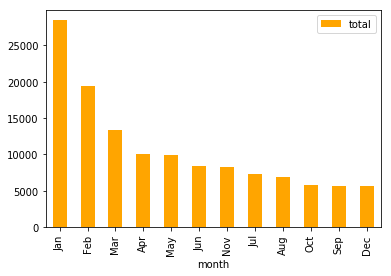

In [71]:
#creat bar chart
data_bar = data_bitcoin['month'].value_counts().rename_axis('month').reset_index(name='total')
data_bar.plot(kind='bar',x='month',y='total', color='orange')

In [ ]:
#load data bitcoin
dict_frame = {}
dict_frame['tweet'] = []
dict_frame['label'] = []
dict_frame['month'] = []
total_data = 0
#loop for each data
print('check : ', end ="")
for data in list_data :
    if (data == "") :
        continue
    print('.', end ="")
    content = json.loads(data)
    dict_frame['tweet'].append(content['tweet'])
    tweet = process_tweet(content['tweet'])
    
    #classify data
    if model.classify(tweet) :
        dict_frame['label'].append('promo')
    else :
        dict_frame['label'].append('news')
        
    date = datetime.datetime.strptime(content['date'], '%Y-%m-%d')
    dict_frame['month'].append(date.strftime('%b'))
    total_data += 1
    
data_bitcoin = pd.DataFrame(dict_frame) 
data_bitcoin.head()

In [75]:
#save file
with open("dataset/bitcoin-classify.js", 'w') as outfile:
    json.dump(dict_frame, outfile)


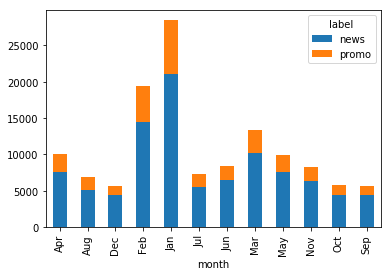

In [76]:
data_bitcoin.groupby(['month','label']).size().unstack().plot(kind='bar',stacked=True)
plt.show()